<a href="https://colab.research.google.com/github/liadmagen/NLP-Course/blob/master/exercises_notebooks/08_LM_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word Embeddings



## Playing with pre-trained word embeddings

Download the pre-trained word vectors; this takes a minute (~1.5gb)

In [1]:
import numpy as np

In [2]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-11-11 18:20:18--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.20.229
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.20.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  44.6MB/s    in 38s     

2020-11-11 18:20:57 (40.8 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



Install `gensim`, a useful NLP library that we will use to load w2v embeddings

In [3]:
!pip install gensim
from gensim.models import KeyedVectors

In [4]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [5]:
word2vec["cat"].shape

(300,)

Recall that $\text{cos}(a,b) = \frac{a \cdot b}{||a|| \cdot  ||b||}$

In [6]:
import numpy as np

def cos(x1, x2):
  return np.dot(x1, x2)/(np.linalg.norm(x1)*np.linalg.norm(x2))

In [7]:
cos(word2vec["cat"], word2vec["dog"])

0.76094574

In [8]:
cos(word2vec["cat"], word2vec["eggplant"])

0.11546826

In [9]:
import random
vocab = random.sample(list(word2vec.vocab), 100)

In [10]:
X = np.array([word2vec[v] for v in vocab])

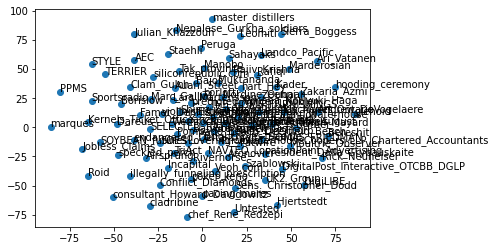

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)


Y = tsne.fit_transform(X)

plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(vocab, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

## Training w2v 

These examples modified from official PyTorch doc: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

### CBoW

In [13]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

vocab = set(raw_text)
vocab_size = len(vocab)

w2i = {word: i for i, word in enumerate(vocab)}
cbow_train = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    cbow_train.append((context, target))
print(cbow_train[:5])

def make_context_vector(context):
    idxs = [w2i[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

make_context_vector(cbow_train[0][0])  # example

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


tensor([20, 19, 10, 38])

In [14]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embed_size):
      super(CBOW, self).__init__()
      self.d = embed_size
      self.E = nn.Embedding(vocab_size, self.d)
      self.a = nn.ReLU()
      self.out = nn.Linear(self.d, vocab_size)
      self.sm = nn.LogSoftmax()

    def forward(self, inputs):
      e = self.E(inputs)
      h = self.a(sum(e))
      return self.sm(self.out(h))

In [15]:
def train_cbow(embed_size=32, hidden_size=32, learning_rate=0.001, n_epoch=20):
    losses = []
    loss_fn = nn.NLLLoss()
    model = CBOW(vocab_size, embed_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = 0.0
        for context, target in cbow_train:
            context_var = make_context_vector(context)
            model.zero_grad()
            # unsqueeze here maps from (d) --> (1 x d)
            log_probs = model(context_var).unsqueeze(0)
            loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data
        
        losses.append(total_loss.numpy())
    return model, losses

epochs = 20
m, losses = train_cbow(epochs)

CBOW(
  (E): Embedding(49, 20)
  (a): ReLU()
  (out): Linear(in_features=20, out_features=49, bias=True)
  (sm): LogSoftmax(dim=None)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


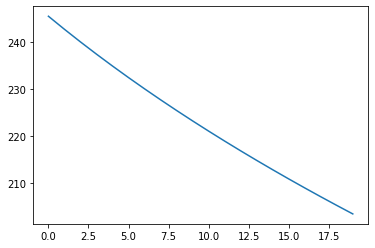

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), losses)

### Skip-gram w/negative sampling

In Skip-gram, we have a pair of input words for each training example.
They consisting of one input target word and one context word, each having a unique numeric identifier. 

If it is a positive sample the word has contextual meaning, is a context word and our label Y=1, else if it is a negative sample, the word has no contextual meaning, is just a random word and our label Y=0. 

In [17]:
import random
skipgram_train, y = [], []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    # positive instance
    for w_c in context:
      skipgram_train.append((w_c, target))
      y.append(1)
      
      # negative (maybe!) instance
      w_rando = random.choice(raw_text)
      skipgram_train.append((w_rando, target))
      y.append(0)
    
print(skipgram_train[:5])
print(y[:5])

[('We', 'about'), ('is', 'about'), ('are', 'about'), ('We', 'about'), ('to', 'about')]
[1, 0, 1, 0, 1]


 We will pass each of them to an **embedding layer** of the size *(vocab_size x embed_size)* which will be trained to contain a dense word embeddings for each of these two words (1 x embed_size for each word)

In [18]:
class SkipGram(nn.Module):

    def __init__(self, vocab_size, embed_size):
      super(SkipGram, self).__init__()
      self.d = embed_size
      self.E = nn.Embedding(vocab_size, self.d)
      self.W = nn.Embedding(vocab_size, self.d)
      self.out = nn.Sigmoid()

    def forward(self, x):
      w_c = self.W(x[0])
      e_t = self.E(x[1])

      # we use a merge layer to compute the dot product of these two embeddings
      return self.out(torch.dot(w_c, e_t))

![Skip-gram structure](https://github.com/liadmagen/NLP-Course/raw/master/images/1_4Uil1zWWF5-jlt-FnRJgAQ.png "Skip-gram model structure")

# Output: the dot product:
vocav_size x embedding_size * embedding_size x vocab_size = vocab_size x vocab_size 

In [19]:
def train_skipgram(embed_size=32, learning_rate=0.001, n_epoch=20):
    losses = []
    loss_fn = nn.BCELoss()
    model = SkipGram(vocab_size, embed_size)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = 0.0
        for idx in range(len(skipgram_train)):
            context = skipgram_train[idx]
            y_i = y[i]
            context_v = make_context_vector(context)
            model.zero_grad()
            # unsqueeze here maps from (d) --> (1 x d)
            y_hat = model(context_v).unsqueeze(0)
            loss = loss_fn(y_hat, Variable(torch.FloatTensor([y_i])))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data
        
        losses.append(total_loss.numpy())
    return model, losses

epochs = 20
m, losses = train_skipgram(epochs)

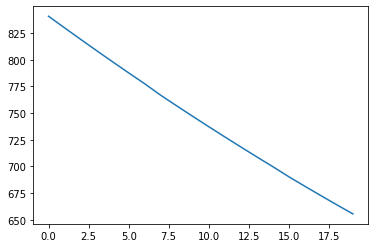

In [20]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), losses)

## How might we use these things?

Back to sentiment classification. ***Disclaimer*** this is not a *good* way of using embeddings, but it is *a* way.

In [21]:
from keras import Sequential
from keras.layers import Dense
from keras.datasets import imdb

In [22]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 0s 0us/step


In [23]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [24]:
embedding_dims = word2vec["cat"].shape[0]

In [25]:
word_to_id = imdb.get_word_index()
id_to_word = {idx:w for w,idx in word_to_id.items()}

def aggregate_embeddings(x):
  sum_of_vectors = np.zeros(embedding_dims)
  for w_idx in x:
    try:
      w = id_to_word[w_idx]
      sum_of_vectors += word2vec[w]
    except:
      pass
  return sum_of_vectors

1646592/1641221 [==============================] - 0s 0us/step


In [26]:
train_data_embedded = []
for x in X_train:
  train_data_embedded.append(aggregate_embeddings(x))
  
test_data_embedded = []
for x in X_test:
  test_data_embedded.append(aggregate_embeddings(x))
  

In [27]:
train_data_embedded = np.array(train_data_embedded)
test_data_embedded = np.array(test_data_embedded)

In [28]:
model = Sequential()

model.add(Dense(32, input_shape=(embedding_dims,)))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adagrad", metrics=['accuracy'])

Q: is this implementation going to update the embeddings???

In [29]:
train_data_embedded.shape

(25000, 300)

In [30]:
model.fit(train_data_embedded, y_train, verbose=True, epochs=20)

Epoch 1/20
782/782 [==============================] - 2s 2ms/step - loss: 1.3583 - accuracy: 0.5328
Epoch 2/20
782/782 [==============================] - 2s 2ms/step - loss: 1.0899 - accuracy: 0.5535
Epoch 3/20
782/782 [==============================] - 2s 2ms/step - loss: 1.0012 - accuracy: 0.5678
Epoch 4/20
782/782 [==============================] - 2s 2ms/step - loss: 0.9420 - accuracy: 0.5763
Epoch 5/20
782/782 [==============================] - 2s 2ms/step - loss: 0.9014 - accuracy: 0.5878
Epoch 6/20
782/782 [==============================] - 2s 2ms/step - loss: 0.8706 - accuracy: 0.5947
Epoch 7/20
782/782 [==============================] - 2s 2ms/step - loss: 0.8473 - accuracy: 0.5994
Epoch 8/20
782/782 [==============================] - 2s 2ms/step - loss: 0.8252 - accuracy: 0.6059
Epoch 9/20
782/782 [==============================] - 2s 2ms/step - loss: 0.8088 - accuracy: 0.6131
Epoch 10/20
782/782 [==============================] - 2s 2ms/step - loss: 0.7936 - accuracy: 0.6166

In [31]:
print(model.evaluate(test_data_embedded, y_test))

782/782 [==============================] - 1s 2ms/step - loss: 0.7094 - accuracy: 0.6413
[0.7094324231147766, 0.641319990158081]


We got about 70% accuracy, just by training a model on a sentence, made from a sum of the word-vectors. 

Not bad, huh? 

But can we do better?

### Fine-Tuning the Embedding per given task

Let's make a version that *does* update embeddings.

First, we initialize a weights matrix.


We are copying the word vectors, one by one, into a matrix, and normalizing them, as discused in the class.

Copying one by one isn't the best way to do it - and many of the framework already offer built-in methods that operate on the machine-level (Assembly / C code) 

In [32]:
num_words = len(id_to_word)+1
d = 300 # embedding dim
E = np.zeros((num_words, d))
for idx, w in id_to_word.items():
    try:
      E[idx,:] = word2vec[w]
    except:
      E[idx,:] = np.random.normal(size=d)

In [33]:
class CBoW_classifier(nn.Module):
  def __init__(self, E):
    super(CBoW_classifier, self).__init__()
       
    # create our embedding layer
    num_words, embedding_dim = E.shape
    self.E_layer = nn.Embedding(num_words, embedding_dim)
    # init with weight matrix (E) created above (passed in here)
    self.E_layer.weight = nn.Parameter(torch.from_numpy(E))
    self.hidden_layer = nn.Linear(embedding_dim, 32)
    self.out = nn.Linear(32, 1)
    self.a = nn.Sigmoid()

  def forward(self, x):
    x_e = self.E_layer(x)
    x_e_sum = torch.sum(x_e, 0) # note: torch.mean() may be better -- why?
    h = self.hidden_layer(x_e_sum.float())
    y_hat = self.out(h)
    return self.a(y_hat)



In [34]:
model = CBoW_classifier(E).cuda()
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
for t in range(10):
    epoch_loss = 0
    for x, y in zip(X_train, y_train):
      x = torch.from_numpy(np.array(x)).long().cuda()
      y_pred = model(x)
      loss = criterion(y_pred.squeeze(0), torch.tensor(y).float().cuda())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
    print(t, epoch_loss)
    

0 11786.42854296781
1 6554.533753025921
2 5082.307396652576
3 3706.1441507865056
4 3842.7571086886524
5 4338.713204022971
6 5197.279513951924
7 6575.852560368944
8 8530.403395625783
9 10764.628054122943


During this training, the embedding vector values had changed, according to the loss calculation. 

PyTorch calculate a computation graph out of the model layers. This graph is computing for every neuron the delta, the change, that need to be updated based on the loss output (called grads - short for gradients).

We can turn on/off which neurons we want to update (or not update) - and we see that in the next exercise.

Let's evaluate how accurate our model is:

In [35]:
model.eval()

for x, y in zip(X_test, y_test):
  x = torch.from_numpy(np.array(x)).long().cuda()
  y_pred = model(x)
  loss = criterion(y_pred.squeeze(0), torch.tensor(y).float().cuda())
  epoch_loss += loss.item()

print(epoch_loss)
  

194940.46059472387
